In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from PIL import Image
from tqdm import tqdm
import time
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Check GPU and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
else:
    print('CUDA not available, using CPU')

# 3. Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# --- 4. Define Constants for 4-Class Project ---

# --- BATCH_SIZE = 192 for high VRAM usage on T4
BATCH_SIZE = 192
GRADIENT_ACCUMULATION_STEPS = 1  # No accumulation needed
# --- NUM_CLASSES = 4
NUM_CLASSES = 4  # CHANGED: honeycombing, crack, spalling, void
IMG_SIZE = 224
# --- NEW: Set to 10 epochs per your request
NUM_EPOCHS = 20
PATIENCE = 10  # Early stopping patience (won't be hit in 10 epochs)

# --- 5. Define Paths for New 4-Class Folder ---

DATA_DIR = '/content/drive/MyDrive/Dataset/Datasets'
# --- NEW: Folder name for all 4-class outputs
PROJECT_FOLDER = '/content/drive/MyDrive/4classwithoutno-defect/'
MODEL_DIR = os.path.join(PROJECT_FOLDER, 'Models/')
RESULTS_DIR = os.path.join(PROJECT_FOLDER, 'Results/')

# Create directories
for dir_path in [MODEL_DIR, RESULTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Directory created/checked: {dir_path}")

# --- 6. Class Mapping and Project ID ---
# --- NEW: 4 classes, including 'void'
class_names = ['honeycombing', 'crack', 'spalling', 'void']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# --- NEW: 4-class project ID
PROJECT_ID = '4class_hcsv'  # honeycombing-crack-spalling-void
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")

print(f'\nSetup complete!')
print(f'Device: {device}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Class mapping: {class_to_idx}')
print(f'Model directory: {MODEL_DIR}')
print(f'Results directory: {RESULTS_DIR}')
print(f'Project ID: {PROJECT_ID}')
print(f'Number of Epochs: {NUM_EPOCHS}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU: Tesla T4
GPU Memory: 14.7 GB
Directory created/checked: /content/drive/MyDrive/4classwithoutno-defect/Models/
Directory created/checked: /content/drive/MyDrive/4classwithoutno-defect/Results/

Setup complete!
Device: cuda
Batch size: 192
Class mapping: {'honeycombing': 0, 'crack': 1, 'spalling': 2, 'void': 3}
Model directory: /content/drive/MyDrive/4classwithoutno-defect/Models/
Results directory: /content/drive/MyDrive/4classwithoutno-defect/Results/
Project ID: 4class_hcsv
Number of Epochs: 20


In [ ]:
# --- 1. Import specific transform and dataset functions ---
# These lines were missing, causing the errors
from torchvision.transforms import Compose, RandomRotation, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip, RandomResizedCrop, GaussianBlur, RandomPerspective
from torchvision.datasets import ImageFolder

# --- 2. Define Data Augmentations ---

# Strong augmentations for the training set
train_transforms = Compose([
    RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.3),
    RandomPerspective(distortion_scale=0.1, p=0.3),
    ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simple preprocessing for validation and test sets
val_transforms = Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Data transforms defined.")

# --- 3. Define Custom Dataset Class ---
# This class lets us load images from the filepaths in our DataFrame

class ConcreteDefectDataset(torch.utils.data.Dataset):
    """Custom dataset class for 4-class concrete defect images"""

    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx or class_to_idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['filepath']
        label = row['label']

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Error loading image {img_path}: {e}")
            # Return a black image as a fallback
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

print("✅ Custom Dataset class 'ConcreteDefectDataset' defined.")

# --- 4. Load, Filter, and Analyze Dataset ---
print("\nLoading dataset and analyzing 4-class distribution...")
# Load all folders found in the DATA_DIR
dataset = ImageFolder(root=DATA_DIR, transform=None)
print(f"Found {len(dataset.classes)} total folders in {DATA_DIR}.")

# Filter dataset to ONLY our 4 target classes
valid_samples = []
for path, original_label in dataset.samples:
    folder_name = os.path.basename(os.path.dirname(path))

    # Only process if the folder matches our target classes
    if folder_name in class_names:
        # Remap label to 0, 1, 2, or 3
        new_label = class_to_idx[folder_name]
        valid_samples.append((path, new_label))

print(f"Filtered to {len(valid_samples)} samples across {len(class_names)} target classes.")

# --- 5. Create and Save Main DataFrame ---
df_data = {
    'filepath': [s[0] for s in valid_samples],
    'label': [s[1] for s in valid_samples],
    'class_name': [class_names[s[1]] for s in valid_samples]
}
df = pd.DataFrame(df_data)

# Save analysis to our results folder
df_path = os.path.join(RESULTS_DIR, f'dataset_analysis_{PROJECT_ID}_{TIMESTAMP}.csv')
df.to_csv(df_path, index=False)
print(f'\n4-class dataset analysis saved to: {df_path}')

# Print class distribution
print('\nFinal 4-Class distribution:')
print(df['class_name'].value_counts())


# --- 6. Define Custom Class Weights (Safer Strategy) ---
print('\n⚖️ Setting up CUSTOM class weights for 4 classes...')

# Using the "safer" 5.0 weight for 'void'
custom_class_weights = {
    'spalling': 1.0,        # Most common, baseline
    'crack': 1.5,           # A bit more important
    'honeycombing': 2.5,    # More important
    'void': 5.0             # HIGHLY important, but not 15.8
}

print('\n🎯 Custom Class Weight Strategy:')
print(f"   • spalling:     {custom_class_weights['spalling']:.1f} (Baseline)")
print(f"   • crack:        {custom_class_weights['crack']:.1f}")
print(f"   • honeycombing: {custom_class_weights['honeycombing']:.1f}")
print(f"   • void:         {custom_class_weights['void']:.1f} (High weight for rare class)")

✅ Data transforms defined.
✅ Custom Dataset class 'ConcreteDefectDataset' defined.

Loading dataset and analyzing 4-class distribution...
Found 5 total folders in /content/drive/MyDrive/Dataset/Datasets.
Filtered to 15798 samples across 4 target classes.

4-class dataset analysis saved to: /content/drive/MyDrive/4classwithoutno-defect/Results/dataset_analysis_4class_hcsv_20251103_1716.csv

Final 4-Class distribution:
class_name
spalling        7908
crack           5000
honeycombing    2368
void             522
Name: count, dtype: int64

⚖️ Setting up CUSTOM class weights for 4 classes...

🎯 Custom Class Weight Strategy:
   • spalling:     1.0 (Baseline)
   • crack:        1.5
   • honeycombing: 2.5
   • void:         5.0 (High weight for rare class)


In [ ]:
# --- 1. Perform Stratified Split (70-15-15) ---
print("Performing stratified 70-15-15 train-validation-test split...")

# First split: 70% train, 30% temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% for val+test
    stratify=df['label'],
    random_state=seed
)

# Second split: Split the 30% into 15% val and 15% test (0.5 * 0.3 = 0.15)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=seed
)

print('\n📊 Dataset Split Summary:')
print(f'  Total samples: {len(df)}')
print(f'  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)')
print(f'  Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)')
print(f'  Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)')

print('\n📊 Train Set Class Distribution:')
print(train_df['class_name'].value_counts())


# --- 2. Create WeightedRandomSampler for Imbalance ---
print("\n⚖️ Creating WeightedRandomSampler to handle class imbalance...")

# Convert weights from dictionary to an array based on class index
# class_names = ['honeycombing', 'crack', 'spalling', 'void']
# custom_class_weights = {'spalling': 1.0, 'crack': 1.5, 'honeycombing': 2.5, 'void': 5.0}
class_weights_array = np.array([custom_class_weights[cls] for cls in class_names])

# Get the labels from the training dataframe
train_labels = train_df['label'].values

# Assign a weight to every single sample in the training set
# e.g., if a sample is 'void' (label 3), it gets weight 5.0
sample_weights = np.array([class_weights_array[label] for label in train_labels])

# Create the sampler
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_labels),
    replacement=True  # Allows oversampling of rare classes
)

print("✅ Sampler created. 'void' and 'honeycombing' will be heavily oversampled.")


# --- 3. Create Dataset Instances ---
train_dataset = ConcreteDefectDataset(train_df, transform=train_transforms, class_to_idx=class_to_idx)
val_dataset = ConcreteDefectDataset(val_df, transform=val_transforms, class_to_idx=class_to_idx)
test_dataset = ConcreteDefectDataset(test_df, transform=val_transforms, class_to_idx=class_to_idx)

print(f"✅ Created {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test datasets.")


# --- 4. Create DataLoaders (Optimized for T4) ---
# Using high batch size and num_workers=2 for parallel loading
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,  # <-- This is the key for imbalance
    num_workers=2,
    pin_memory=True,
    drop_last=True  # Drops the last non-full batch, good for training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling or sampling for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling or sampling for test
    num_workers=2,
    pin_memory=True
)

print(f'\n✅ DataLoaders created!')
print(f'   Train batches: {len(train_loader)} (Batch size: {BATCH_SIZE})')
print(f'   Validation batches: {len(val_loader)}')
print(f'   Test batches: {len(test_loader)}')


# --- 5. Save Split Info and DataFrames ---
print("\n💾 Saving split information and DataFrames to Google Drive...")

# Save split dataframes
train_df.to_csv(os.path.join(RESULTS_DIR, f'train_split_{PROJECT_ID}_{TIMESTAMP}.csv'), index=False)
val_df.to_csv(os.path.join(RESULTS_DIR, f'val_split_{PROJECT_ID}_{TIMESTAMP}.csv'), index=False)
test_df.to_csv(os.path.join(RESULTS_DIR, f'test_split_{PROJECT_ID}_{TIMESTAMP}.csv'), index=False)

# Save comprehensive split info
split_info = {
    'dataset_split': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
    },
    'custom_class_weights': {
        'strategy': "Safer, damped weights for severe imbalance",
        'weights': custom_class_weights,
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'effective_batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
    }
}

split_info_path = os.path.join(RESULTS_DIR, f'split_info_{PROJECT_ID}_{TIMESTAMP}.json')
with open(split_info_path, 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"   Split data saved to: {RESULTS_DIR}")
print('\n🚀 Ready for model definition and training setup.')

Performing stratified 70-15-15 train-validation-test split...

📊 Dataset Split Summary:
  Total samples: 15798
  Train: 11058 (70.0%)
  Validation: 2370 (15.0%)
  Test: 2370 (15.0%)

📊 Train Set Class Distribution:
class_name
spalling        5535
crack           3500
honeycombing    1658
void             365
Name: count, dtype: int64

⚖️ Creating WeightedRandomSampler to handle class imbalance...
✅ Sampler created. 'void' and 'honeycombing' will be heavily oversampled.
✅ Created 11058 train, 2370 val, 2370 test datasets.

✅ DataLoaders created!
   Train batches: 57 (Batch size: 192)
   Validation batches: 13
   Test batches: 13

💾 Saving split information and DataFrames to Google Drive...
   Split data saved to: /content/drive/MyDrive/4classwithoutno-defect/Results/

🚀 Ready for model definition and training setup.


In [ ]:
# --- 1. Define Custom Focal Loss ---
# This loss function is great for imbalance.
# It will use our custom_class_weights as 'alpha'.

class FocalLoss(nn.Module):
    """
    Focal Loss implementation.
    alpha = class weights
    gamma = focusing parameter
    """
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy loss, applying our 'alpha' weights
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)

        # Compute p_t (the probability of the correct class)
        pt = torch.exp(-ce_loss)

        # Compute the focal weight (1 - pt)^gamma
        focal_weight = (1 - pt) ** self.gamma

        # Apply the focal weight to the cross entropy loss
        focal_loss = focal_weight * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Custom 'FocalLoss' class defined.")


# --- 2. Initialize ResNet50 Model ---
print("🏗️ Initializing ResNet50 model for 4-class classification...")
# Use the modern 'weights' API to load pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Replace the final fully connected layer for 4-class classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout for regularization
    nn.Linear(num_ftrs, NUM_CLASSES)  # Output layer for 4 classes
)

# Move model to the GPU
model = model.to(device)

print(f"✅ Model loaded on {device}.")
print(f"   Model output features: {NUM_CLASSES}")


# --- 3. Define Optimizer and Scheduler ---
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,           # Standard learning rate for fine-tuning
    weight_decay=1e-5  # L2 regularization
)

# Scheduler monitors validation F1 score and reduces LR if it plateaus
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',           # We want to maximize F1 score
    factor=0.5,           # Reduce LR by half
    patience=5,           # Wait 5 epochs before reducing
    min_lr=1e-7
)

print("✅ Adam Optimizer and ReduceLROnPlateau Scheduler defined.")


# --- 4. Initialize Loss Function and Scaler ---

# Convert our custom class weights (from Cell 2) into a tensor
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# Initialize Focal Loss, passing our weights as the 'alpha' parameter
criterion = FocalLoss(
    alpha=class_weights_tensor,
    gamma=2,  # Standard gamma value
    reduction='mean'
)

# Initialize a GradScaler for mixed-precision training
scaler = torch.amp.GradScaler('cuda' if device.type == 'cuda' else 'cpu', enabled=(device.type == 'cuda'))

print("✅ Focal Loss (with custom weights) and GradScaler defined.")


# --- 5. Final Setup Summary ---
print("\n" + "="*50)
print("🎯 Training components initialized:")
print(f"  • Model: ResNet50 (pretrained)")
print(f"  • Classes: {NUM_CLASSES} - {class_names}")
print(f"  • Loss: Focal Loss (γ=2)")
print(f"  • Optimizer: Adam (lr=1e-4)")
print(f"  • Scheduler: ReduceLROnPlateau (monitor val_macro_f1)")
print(f"  • Custom weights (alpha):")
for cls, w in custom_class_weights.items():
    print(f"    - {cls}: {w}")
print(f"  • Mixed Precision: {'Enabled' if device.type == 'cuda' else 'Disabled'}")
print("="*50)

print("\n🚀 Ready for training.")

✅ Custom 'FocalLoss' class defined.
🏗️ Initializing ResNet50 model for 4-class classification...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:04<00:00, 24.7MB/s]


✅ Model loaded on cuda.
   Model output features: 4
✅ Adam Optimizer and ReduceLROnPlateau Scheduler defined.
✅ Focal Loss (with custom weights) and GradScaler defined.

🎯 Training components initialized:
  • Model: ResNet50 (pretrained)
  • Classes: 4 - ['honeycombing', 'crack', 'spalling', 'void']
  • Loss: Focal Loss (γ=2)
  • Optimizer: Adam (lr=1e-4)
  • Scheduler: ReduceLROnPlateau (monitor val_macro_f1)
  • Custom weights (alpha):
    - spalling: 1.0
    - crack: 1.5
    - honeycombing: 2.5
    - void: 5.0
  • Mixed Precision: Enabled

🚀 Ready for training.


In [ ]:
# --- 1. Define the Main Training Function ---
def run_training():

    # --- NEW: Overriding Epochs and Patience per your request ---
    NUM_EPOCHS = 10
    PATIENCE = 7
    # --- End of NEW ---

    best_macro_f1 = 0.0  # Keep track of the best F1 score
    patience_counter = 0   # Keep track of epochs with no improvement

    # Store history
    train_losses = []
    val_losses = []
    val_macro_f1_scores = []

    print(f"\n🚀 Starting 4-class ResNet50 training for {NUM_EPOCHS} epochs...")
    print(f"   Batch Size: {BATCH_SIZE}, Patience: {PATIENCE}")
    print(f"   Weighted Sampler: ENABLED (Void weight: {custom_class_weights['void']})")
    print(f"   Loss Function: Focal Loss")

    # --- Main Epoch Loop ---
    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_start_time = time.time()
        print(f"\n{'='*70}")
        print(f"EPOCH {epoch}/{NUM_EPOCHS}")
        print(f"{'='*70}")

        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0

        # Use tqdm for a progress bar
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)

        for images, labels in pbar_train:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

            # Update progress bar description
            pbar_train.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        pbar_train.close()

        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)

        with torch.no_grad():
            for images, labels in pbar_val:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True) # <-- Labels are on GPU here

                with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                # Get predictions
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())

                # --- THIS IS THE FIX ---
                # You must move 'labels' to CPU before calling .numpy()
                all_labels.extend(labels.cpu().numpy())
                # --- END OF FIX ---

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        pbar_val.close()

        # --- METRICS, SCHEDULING, and SAVING ---

        # Calculate validation Macro F1 score
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        val_macro_f1_scores.append(val_macro_f1)

        # Update the learning rate scheduler
        scheduler.step(val_macro_f1)

        epoch_time = time.time() - epoch_start_time
        peak_gpu = torch.cuda.max_memory_allocated(device) / 1024**3 if device.type == 'cuda' else 0

        # Print epoch results
        print(f"\n📊 EPOCH {epoch} RESULTS:")
        print(f"   Time:       {epoch_time:.1f}s")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Val Loss:   {avg_val_loss:.4f}")
        print(f"   Val F1:     {val_macro_f1:.4f} (Macro)")
        print(f"   GPU Peak:   {peak_gpu:.1f}GB")
        print(f"   LR:         {optimizer.param_groups[0]['lr']:.2e}")

        # Check for new best model
        if val_macro_f1 > best_macro_f1:
            best_macro_f1 = val_macro_f1
            patience_counter = 0  # Reset patience

            print(f"   🏆 NEW BEST MODEL! F1: {best_macro_f1:.4f}")

            # Save checkpoint
            checkpoint_path = os.path.join(MODEL_DIR, f'best_model_{PROJECT_ID}_{TIMESTAMP}.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_f1': best_macro_f1,
                'class_names': class_names,
                'custom_weights': custom_class_weights,
            }, checkpoint_path)
            print(f"   💾 Model saved to: {checkpoint_path}")

        else:
            patience_counter += 1
            print(f"   ⏳ No improvement. Best F1: {best_macro_f1:.4f} (Patience: {patience_counter}/{PATIENCE})")

        # Check for early stopping
        if patience_counter >= PATIENCE:
            print(f"\n⏹️ Early stopping triggered at epoch {epoch}!")
            break

        # Clear cache
        if device.type == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

    print(f"\n🎉 Training complete! Best Validation Macro F1: {best_macro_f1:.4f}")
    return best_macro_f1

# --- 2. Run the Training ---
try:
    best_score = run_training()
    print(f"\n✅ SUCCESS! Best 4-class macro F1: {best_score:.4f}")

    # --- 3. Load the Best Model Weights ---
    # After training, load the best-performing weights for evaluation
    best_model_path = os.path.join(MODEL_DIR, f'best_model_{PROJECT_ID}_{TIMESTAMP}.pth')
    if os.path.exists(best_model_path):
        print(f"\nLoading best model from: {best_model_path}")
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✅ Best model weights loaded for evaluation.")
    else:
        print("⚠️ Warning: No best model checkpoint found. Using the model from the last epoch.")

except Exception as e:
    print(f"❌ Training error: {e}")
    import traceback
    traceback.print_exc()
    if "out of memory" in str(e).lower():
        print("💡 OOM Error: Try reducing BATCH_SIZE (e.g., 128 or 96) in Cell 1 and restart.")


🚀 Starting 4-class ResNet50 training for 10 epochs...
   Batch Size: 192, Patience: 7
   Weighted Sampler: ENABLED (Void weight: 5.0)
   Loss Function: Focal Loss

EPOCH 1/10



📊 EPOCH 1 RESULTS:
   Time:       1284.3s
   Train Loss: 0.0443
   Val Loss:   0.0285
   Val F1:     0.9828 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   🏆 NEW BEST MODEL! F1: 0.9828
   💾 Model saved to: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_4class_hcsv_20251103_1716.pth

EPOCH 2/10



📊 EPOCH 2 RESULTS:
   Time:       426.8s
   Train Loss: 0.0335
   Val Loss:   0.0229
   Val F1:     0.9848 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   🏆 NEW BEST MODEL! F1: 0.9848
   💾 Model saved to: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_4class_hcsv_20251103_1716.pth

EPOCH 3/10



📊 EPOCH 3 RESULTS:
   Time:       293.1s
   Train Loss: 0.0173
   Val Loss:   0.0388
   Val F1:     0.9708 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   ⏳ No improvement. Best F1: 0.9848 (Patience: 1/7)

EPOCH 4/10



📊 EPOCH 4 RESULTS:
   Time:       217.3s
   Train Loss: 0.0202
   Val Loss:   0.0232
   Val F1:     0.9851 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   🏆 NEW BEST MODEL! F1: 0.9851
   💾 Model saved to: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_4class_hcsv_20251103_1716.pth

EPOCH 5/10



📊 EPOCH 5 RESULTS:
   Time:       204.0s
   Train Loss: 0.0158
   Val Loss:   0.0253
   Val F1:     0.9870 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   🏆 NEW BEST MODEL! F1: 0.9870
   💾 Model saved to: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_4class_hcsv_20251103_1716.pth

EPOCH 6/10



📊 EPOCH 6 RESULTS:
   Time:       192.0s
   Train Loss: 0.0109
   Val Loss:   0.0188
   Val F1:     0.9860 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   ⏳ No improvement. Best F1: 0.9870 (Patience: 1/7)

EPOCH 7/10



📊 EPOCH 7 RESULTS:
   Time:       182.1s
   Train Loss: 0.0090
   Val Loss:   0.0205
   Val F1:     0.9843 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   ⏳ No improvement. Best F1: 0.9870 (Patience: 2/7)

EPOCH 8/10



📊 EPOCH 8 RESULTS:
   Time:       182.9s
   Train Loss: 0.0100
   Val Loss:   0.0279
   Val F1:     0.9776 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   ⏳ No improvement. Best F1: 0.9870 (Patience: 3/7)

EPOCH 9/10



📊 EPOCH 9 RESULTS:
   Time:       179.8s
   Train Loss: 0.0046
   Val Loss:   0.0244
   Val F1:     0.9844 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   ⏳ No improvement. Best F1: 0.9870 (Patience: 4/7)

EPOCH 10/10



📊 EPOCH 10 RESULTS:
   Time:       178.4s
   Train Loss: 0.0039
   Val Loss:   0.0196
   Val F1:     0.9879 (Macro)
   GPU Peak:   8.3GB
   LR:         1.00e-04
   🏆 NEW BEST MODEL! F1: 0.9879
   💾 Model saved to: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_4class_hcsv_20251103_1716.pth

🎉 Training complete! Best Validation Macro F1: 0.9879

✅ SUCCESS! Best 4-class macro F1: 0.9879

Loading best model from: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_4class_hcsv_20251103_1716.pth
✅ Best model weights loaded for evaluation.


✅ Evaluation and plotting functions defined.

🧪 Evaluating 4-class model on VALIDATION SET...
   Classes: ['honeycombing', 'crack', 'spalling', 'void']


Evaluating on VALIDATION: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]



🏆 4-CLASS VALIDATION SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9966 (99.66%)
📈 Macro F1-Score: 0.9879
🎯 Weighted F1-Score: 0.9966
💾 GPU Memory: Peak 1.8GB during evaluation

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    0.997      0.983      0.990      355        2.5
crack           0.999      1.000      0.999      750        1.5
spalling        0.999      0.999      0.999      1186       1.0
void            0.940      0.987      0.963      79         5.0
--------------------------------------------------------------------------------
Macro Avg       0.984      0.992      0.988      2370      

💡 Performance Insights:
   ✅ Best performing: crack (F1: 0.999)
   ⚠️ Needs improvement: void (F1: 0.963)
   📈 Average prediction confidence: 0.987

📊

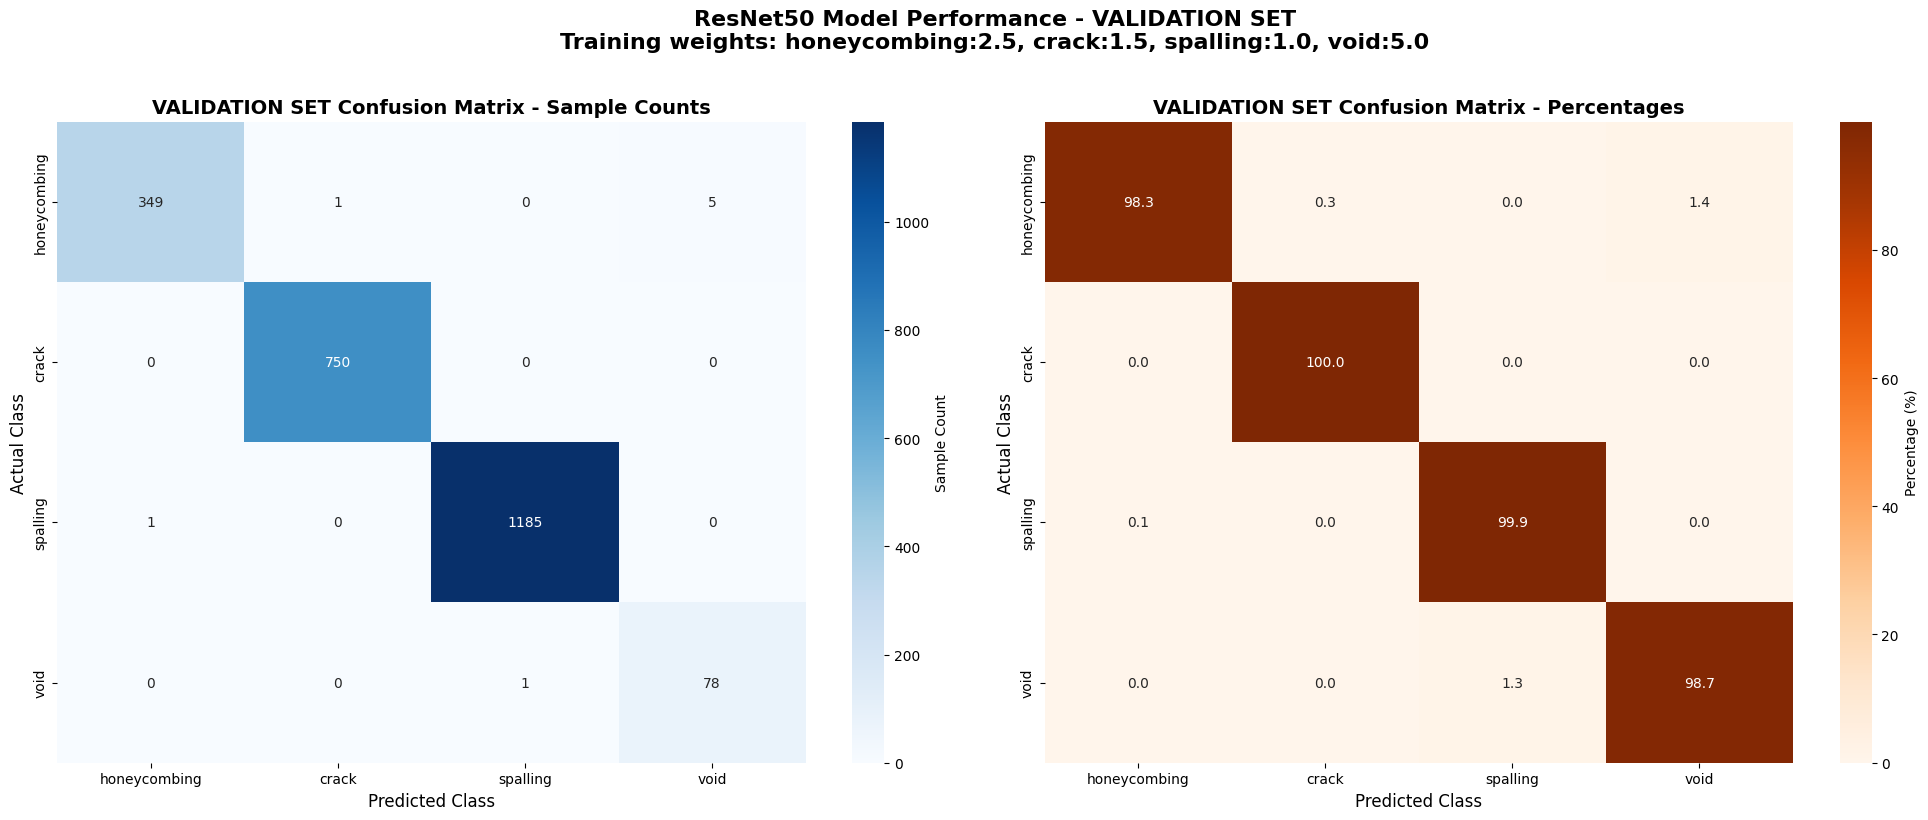

In [ ]:
# --- 1. Define the 4-Class Evaluation Function ---
# This function will run the model on a data loader and print a full report

def evaluate_model(loader, data_set_name="Validation"):
    """Comprehensive evaluation for the 4-class model"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    print(f"\n🧪 Evaluating 4-class model on {data_set_name} SET...")
    print(f"   Classes: {class_names}")

    with torch.no_grad():
        # Use tqdm for a progress bar
        for images, labels in tqdm(loader, desc=f"Evaluating on {data_set_name}"):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(images)

            # Get probabilities and predictions
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_probs = np.array(all_probs)
    peak_gpu = torch.cuda.max_memory_allocated(device) / 1024**3 if device.type == 'cuda' else 0

    # --- 2. Calculate Metrics ---
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # --- 3. Print Comprehensive Report ---
    print("\n" + "="*80)
    print(f"🏆 4-CLASS {data_set_name} SET - EVALUATION RESULTS 🏆")
    print("="*80)
    print(f"📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📈 Macro F1-Score: {macro_f1:.4f}")
    print(f"🎯 Weighted F1-Score: {weighted_f1:.4f}")
    print(f"💾 GPU Memory: Peak {peak_gpu:.1f}GB during evaluation")

    print("\n📋 4-Class Performance Breakdown:")
    print("-" * 80)
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Support':<10} {'Weight Applied'}")
    print("-" * 80)

    for i, class_name in enumerate(class_names):
        weight = custom_class_weights.get(class_name, 1.0)
        print(f"{class_name:<15} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1[i]:<10.3f} {support[i]:<10.0f} {weight:.1f}")

    print("-" * 80)
    print(f"{'Macro Avg':<15} {np.mean(precision):<10.3f} {np.mean(recall):<10.3f} {macro_f1:<10.3f} {sum(support):<10.0f}")

    print(f"\n💡 Performance Insights:")
    best_class_idx = np.argmax(f1)
    worst_class_idx = np.argmin(f1)
    print(f"   ✅ Best performing: {class_names[best_class_idx]} (F1: {f1[best_class_idx]:.3f})")
    print(f"   ⚠️ Needs improvement: {class_names[worst_class_idx]} (F1: {f1[worst_class_idx]:.3f})")

    avg_confidence = np.mean(np.max(all_probs, axis=1))
    print(f"   📈 Average prediction confidence: {avg_confidence:.3f}")

    print(f"\n📊 Detailed 4-Class Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Return all results
    return {
        'accuracy': accuracy, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1,
        'per_class_f1': f1, 'per_class_precision': precision, 'per_class_recall': recall,
        'support': support, 'confusion_matrix': cm, 'predictions': all_preds,
        'true_labels': all_labels, 'probabilities': all_probs
    }


# --- 4. Define the 4-Class Confusion Matrix Plotting Function ---

def plot_confusion_matrix(true_labels, predictions, class_names, title_prefix=""):
    """Enhanced confusion matrix for 4-class concrete defect detection"""
    cm = confusion_matrix(true_labels, predictions)
    # Calculate percentages, adding 1e-6 to avoid division by zero
    cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # Wider for 4 classes

    # Plot 1: Absolute numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': 'Sample Count'})
    ax1.set_title(f'{title_prefix} Confusion Matrix - Sample Counts', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Class', fontsize=12)
    ax1.set_ylabel('Actual Class', fontsize=12)

    # Plot 2: Percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'label': 'Percentage (%)'})
    ax2.set_title(f'{title_prefix} Confusion Matrix - Percentages', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Class', fontsize=12)
    ax2.set_ylabel('Actual Class', fontsize=12)

    # Add custom weight information
    weight_text = "Training weights: " + ", ".join([f"{cls}:{custom_class_weights[cls]}" for cls in class_names])
    fig.suptitle(f'ResNet50 Model Performance - {title_prefix}\n{weight_text}', fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

print("✅ Evaluation and plotting functions defined.")


# --- 5. Run Evaluation on VALIDATION Set ---
val_results = evaluate_model(val_loader, data_set_name="VALIDATION")
plot_confusion_matrix(val_results['true_labels'], val_results['predictions'], class_names, title_prefix="VALIDATION SET")


🏆 Running Final Evaluation on the TEST SET 🏆

🧪 Evaluating 4-class model on TEST SET...
   Classes: ['honeycombing', 'crack', 'spalling', 'void']


Evaluating on TEST: 100%|██████████| 13/13 [10:35<00:00, 48.87s/it]



🏆 4-CLASS TEST SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9970 (99.70%)
📈 Macro F1-Score: 0.9897
🎯 Weighted F1-Score: 0.9971
💾 GPU Memory: Peak 1.8GB during evaluation

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    1.000      0.983      0.991      355        2.5
crack           1.000      0.999      0.999      750        1.5
spalling        0.998      1.000      0.999      1187       1.0
void            0.940      1.000      0.969      78         5.0
--------------------------------------------------------------------------------
Macro Avg       0.985      0.995      0.990      2370      

💡 Performance Insights:
   ✅ Best performing: crack (F1: 0.999)
   ⚠️ Needs improvement: void (F1: 0.969)
   📈 Average prediction confidence: 0.988

📊 Detai

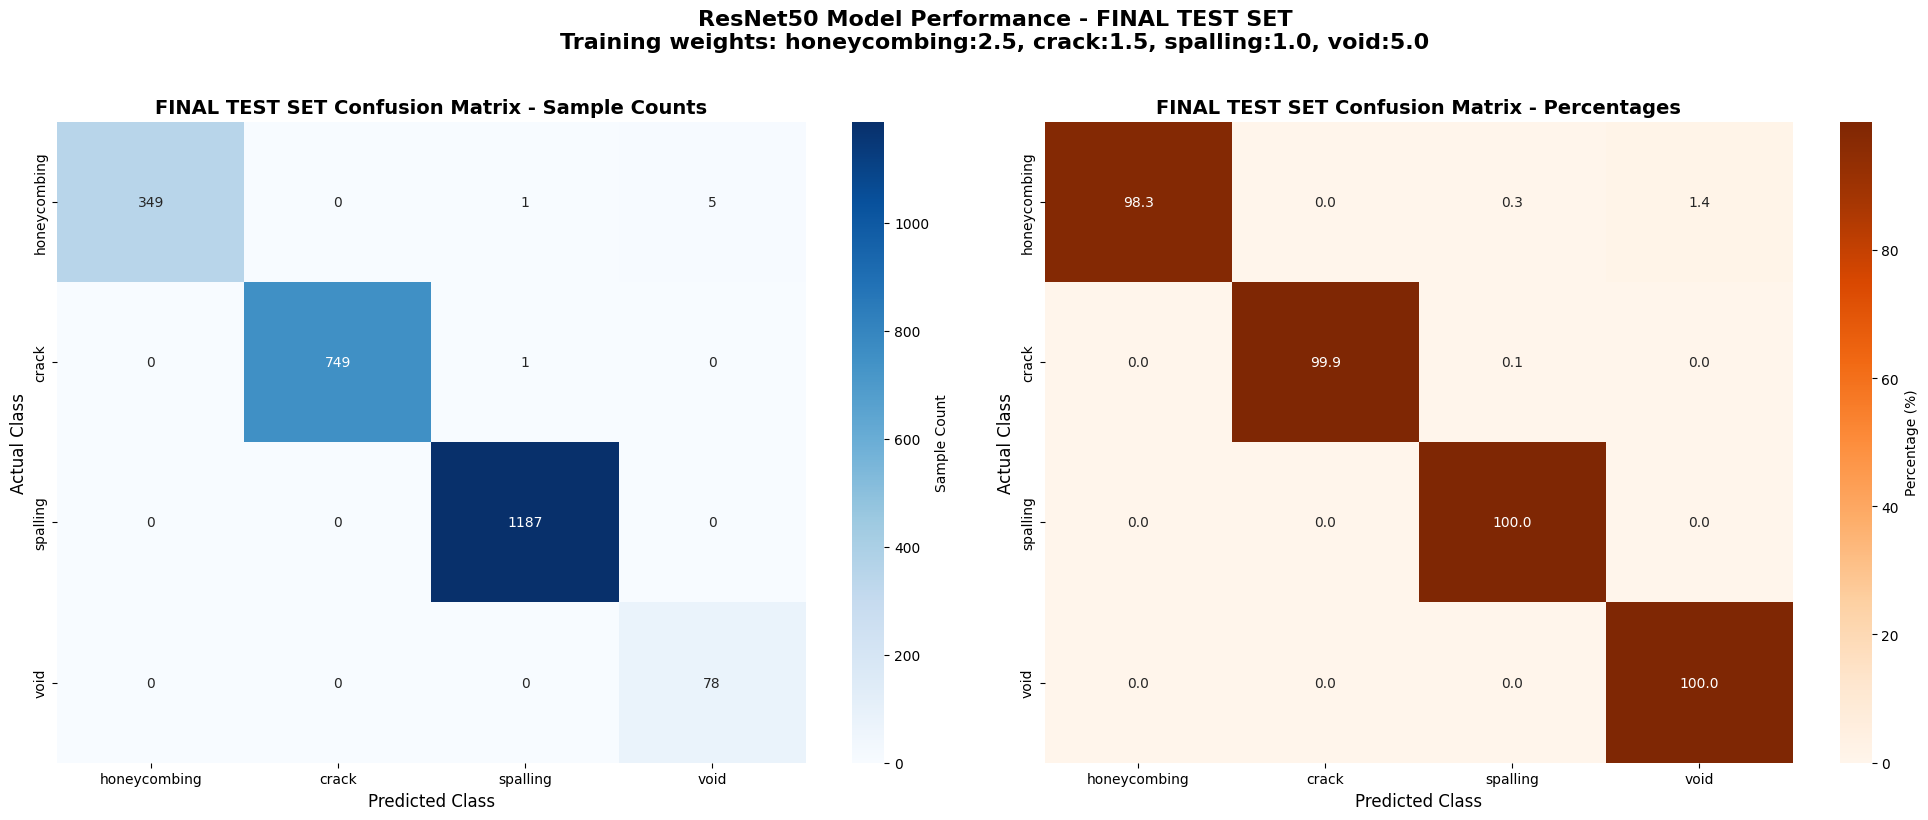


💾 Saving FINAL TEST SET evaluation results to Google Drive...
   Test results saved to: /content/drive/MyDrive/4classwithoutno-defect/Results/evaluation_results_TEST_4class_hcsv_20251103_1716.json

🎉🎉 --- All steps complete! --- 🎉🎉


In [ ]:
# --- 1. Run Evaluation on the FINAL TEST Set ---
print("\n" + "="*80)
print("🏆 Running Final Evaluation on the TEST SET 🏆")
print("="*80)

# The model (with best weights loaded) is evaluated on the test_loader
test_results = evaluate_model(test_loader, data_set_name="TEST")


# --- 2. Plot the FINAL TEST Confusion Matrix ---
print("\n🎨 Creating FINAL TEST SET confusion matrix...")
plot_confusion_matrix(test_results['true_labels'],
                      test_results['predictions'],
                      class_names,
                      title_prefix="FINAL TEST SET")


# --- 3. Save Final TEST Results to a JSON file ---
print("\n💾 Saving FINAL TEST SET evaluation results to Google Drive...")

# Create a summary dictionary
test_eval_summary = {
    'model_type': 'ResNet50',
    'num_classes': len(class_names),
    'class_names': class_names,
    'project_id': PROJECT_ID,
    'timestamp': TIMESTAMP,
    'batch_size': BATCH_SIZE,
    'custom_weights': custom_class_weights,
    'accuracy': float(test_results['accuracy']),
    'macro_f1': float(test_results['macro_f1']),
    'weighted_f1': float(test_results['weighted_f1']),
    'per_class_metrics': {
        class_names[i]: {
            'precision': float(test_results['per_class_precision'][i]),
            'recall': float(test_results['per_class_recall'][i]),
            'f1': float(test_results['per_class_f1'][i]),
            'support': int(test_results['support'][i])
        } for i in range(len(class_names))
    }
}

# Define the save path
test_eval_path = os.path.join(RESULTS_DIR, f'evaluation_results_TEST_{PROJECT_ID}_{TIMESTAMP}.json')

# Save the file
with open(test_eval_path, 'w') as f:
    json.dump(test_eval_summary, f, indent=4)

print(f"   Test results saved to: {test_eval_path}")
print("\n🎉🎉 --- All steps complete! --- 🎉🎉")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
# --- NEW: Added StratifiedKFold ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from PIL import Image
from tqdm import tqdm
import time
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Check GPU and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
else:
    print('CUDA not available, using CPU')

# 3. Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# --- 4. Define Constants for 4-Class Project ---
BATCH_SIZE = 192
GRADIENT_ACCUMULATION_STEPS = 1
NUM_CLASSES = 4  # honeycombing, crack, spalling, void
IMG_SIZE = 224
# --- SETTING EPOCHS AND PATIENCE ---
NUM_EPOCHS = 10
PATIENCE = 5

# --- 5. Define Paths for New 4-Class Folder ---
DATA_DIR = '/content/drive/MyDrive/Dataset/Datasets'
PROJECT_FOLDER = '/content/drive/MyDrive/4classwithoutno-defect/'
MODEL_DIR = os.path.join(PROJECT_FOLDER, 'Models/')
RESULTS_DIR = os.path.join(PROJECT_FOLDER, 'Results/')

# Create directories
for dir_path in [MODEL_DIR, RESULTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Directory created/checked: {dir_path}")

# --- 6. Class Mapping and Project ID ---
class_names = ['honeycombing', 'crack', 'spalling', 'void']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
PROJECT_ID = '4class_kfold_hcsv'  # --- NEW: K-Fold Project ID
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")

print(f'\nSetup complete!')
print(f'Device: {device}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Class mapping: {class_to_idx}')
print(f'Model directory: {MODEL_DIR}')
print(f'Results directory: {RESULTS_DIR}')
print(f'Project ID: {PROJECT_ID}')
print(f'Number of Epochs per fold: {NUM_EPOCHS}')
print(f'Patience per fold: {PATIENCE}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU: Tesla T4
GPU Memory: 14.7 GB
Directory created/checked: /content/drive/MyDrive/4classwithoutno-defect/Models/
Directory created/checked: /content/drive/MyDrive/4classwithoutno-defect/Results/

Setup complete!
Device: cuda
Batch size: 192
Class mapping: {'honeycombing': 0, 'crack': 1, 'spalling': 2, 'void': 3}
Model directory: /content/drive/MyDrive/4classwithoutno-defect/Models/
Results directory: /content/drive/MyDrive/4classwithoutno-defect/Results/
Project ID: 4class_kfold_hcsv
Number of Epochs per fold: 10
Patience per fold: 5


In [ ]:
# --- 1. Import necessary functions ---
from torchvision.transforms import Compose, RandomRotation, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip, RandomResizedCrop, GaussianBlur, RandomPerspective
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from tqdm import tqdm

# --- 2. Define Data Augmentations ---
train_transforms = Compose([
    RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.3),
    RandomPerspective(distortion_scale=0.1, p=0.3),
    ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("✅ Data transforms defined.")

# --- 3. Define Custom Dataset Class ---
class ConcreteDefectDataset(torch.utils.data.Dataset):
    """Custom dataset class for 4-class concrete defect images"""
    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = class_to_idx or class_to_idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['filepath']
        label = row['label']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Error loading image {img_path}: {e}")
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, label
print("✅ Custom Dataset class 'ConcreteDefectDataset' defined.")

# --- 4. Define Image Hashing Function ---
def compute_image_hash(filepath):
    """Computes a 64-bit 'average hash' (fingerprint) for an image."""
    try:
        img = Image.open(filepath).resize((8, 8), Image.LANCZOS).convert('L')
        pixels = np.array(img.getdata())
        avg_pixel = pixels.mean()
        hash_bits = (pixels > avg_pixel).astype(int)
        return "".join(hash_bits.astype(str))
    except Exception as e:
        print(f"Error hashing image {filepath}: {e}")
        return None
print("✅ Image hashing function 'compute_image_hash' defined.")

# --- 5. Load, Filter, and Hash Dataset ---
print("\nLoading dataset and analyzing 4-class distribution...")
dataset = ImageFolder(root=DATA_DIR, transform=None)
print(f"Found {len(dataset.classes)} total folders in {DATA_DIR}.")

# Filter dataset to ONLY our 4 target classes
valid_samples = []
for path, original_label in dataset.samples:
    folder_name = os.path.basename(os.path.dirname(path))
    if folder_name in class_names:
        new_label = class_to_idx[folder_name]
        valid_samples.append((path, new_label))
print(f"Filtered to {len(valid_samples)} samples across {len(class_names)} target classes.")

# Create main DataFrame
df_data = {
    'filepath': [s[0] for s in valid_samples],
    'label': [s[1] for s in valid_samples],
    'class_name': [class_names[s[1]] for s in valid_samples]
}
df = pd.DataFrame(df_data)
print(f"\nCreated main DataFrame with {len(df)} total images.")

# --- 6. Compute Hashes for All Images (This will take a few minutes) ---
print(f"Starting to compute hashes for {len(df)} images...")
tqdm.pandas(desc="Hashing Images")
df['image_hash'] = df['filepath'].progress_apply(compute_image_hash)
print("✅ Hashing complete.")

# Analyze duplicates
total_images = len(df)
unique_images = df['image_hash'].nunique()
duplicate_images = total_images - unique_images
print(f"\n--- Duplicate Analysis ---")
print(f"  Total images:    {total_images}")
print(f"  Unique images:   {unique_images}")
print(f"  Duplicate images:  {duplicate_images} (to be removed in next step)")
print(f"--------------------------")

# --- 7. Define Custom Class Weights (Safer Strategy) ---
print('\n⚖️ Setting up CUSTOM class weights for 4 classes...')
custom_class_weights = {
    'spalling': 1.0,
    'crack': 1.5,
    'honeycombing': 2.5,
    'void': 5.0  # Safer, strong weight for the rare class
}
print('\n🎯 Custom Class Weight Strategy:')
print(f"   • spalling:     {custom_class_weights['spalling']:.1f} (Baseline)")
print(f"   • crack:        {custom_class_weights['crack']:.1f}")
print(f"   • honeycombing: {custom_class_weights['honeycombing']:.1f}")
print(f"   • void:         {custom_class_weights['void']:.1f} (High weight)")

✅ Data transforms defined.
✅ Custom Dataset class 'ConcreteDefectDataset' defined.
✅ Image hashing function 'compute_image_hash' defined.

Loading dataset and analyzing 4-class distribution...
Found 5 total folders in /content/drive/MyDrive/Dataset/Datasets.
Filtered to 15798 samples across 4 target classes.

Created main DataFrame with 15798 total images.
Starting to compute hashes for 15798 images...


Hashing Images: 100%|██████████| 15798/15798 [1:28:52<00:00,  2.96it/s]

✅ Hashing complete.

--- Duplicate Analysis ---
  Total images:    15798
  Unique images:   14871
  Duplicate images:  927 (to be removed in next step)
--------------------------

⚖️ Setting up CUSTOM class weights for 4 classes...

🎯 Custom Class Weight Strategy:
   • spalling:     1.0 (Baseline)
   • crack:        1.5
   • honeycombing: 2.5
   • void:         5.0 (High weight)


In [ ]:
# --- 1. De-duplicate the DataFrame ---
print(f"Original image count: {len(df)}")
print(f"Unique image hashes: {df['image_hash'].nunique()}")

# Keep the first instance of each hash, drop all subsequent duplicates
df_clean = df.drop_duplicates(subset=['image_hash'], keep='first')

print(f"Clean (de-duplicated) image count: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} duplicate images.")


# --- 2. Create the Main 80/20 Split (Train-Val Pool / Test Set) ---
print("\nSplitting clean data into 80% (Train+Val Pool) and 20% (Test Set)...")

# We will split the clean dataframe 'df_clean'
# We need the labels (y) for stratification
labels = df_clean['label']

# Split into 80% train_val_pool and 20% test_set
train_val_df, test_df = train_test_split(
    df_clean,
    test_size=0.2,          # 20% for the final held-out test set
    stratify=labels,      # Ensure stratification on the clean data
    random_state=seed
)

print("\n--- Final Data Split ---")
print(f"Total Clean Samples: {len(df_clean)}")
print(f"Train/Val Pool (80%): {len(train_val_df)} samples")
print(f"Test Set (20%):       {len(test_df)} samples")

print("\nDistribution in Train/Val Pool:")
print(train_val_df['class_name'].value_counts())

print("\nDistribution in Test Set:")
print(test_df['class_name'].value_counts())


# --- 3. Save the Clean, Split DataFrames ---
print("\n💾 Saving de-duplicated and split DataFrames...")

# Save the main clean dataframe (optional, but good for records)
df_clean.to_csv(os.path.join(RESULTS_DIR, f'dataset_clean_{PROJECT_ID}_{TIMESTAMP}.csv'), index=False)

# Save the two main splits
train_val_df.to_csv(os.path.join(RESULTS_DIR, f'train_val_pool_split_{PROJECT_ID}_{TIMESTAMP}.csv'), index=False)
test_df.to_csv(os.path.join(RESULTS_DIR, f'test_set_split_{PROJECT_ID}_{TIMESTAMP}.csv'), index=False)

print(f"   Clean data splits saved to: {RESULTS_DIR}")


# --- 4. Define the K-Fold Cross-Validator ---
N_SPLITS = 5  # We will do 5-fold cross-validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

print(f"\n✅ Ready for {N_SPLITS}-Fold Cross-Validation.")
print("   We will loop 5 times, splitting the 11,896-sample 'Train/Val Pool'.")
print("   The 2,975-sample 'Test Set' remains locked away.")

Original image count: 15798
Unique image hashes: 14871
Clean (de-duplicated) image count: 14871
Removed 927 duplicate images.

Splitting clean data into 80% (Train+Val Pool) and 20% (Test Set)...

--- Final Data Split ---
Total Clean Samples: 14871
Train/Val Pool (80%): 11896 samples
Test Set (20%):       2975 samples

Distribution in Train/Val Pool:
class_name
spalling        6113
crack           3739
honeycombing    1836
void             208
Name: count, dtype: int64

Distribution in Test Set:
class_name
spalling        1529
crack            935
honeycombing     459
void              52
Name: count, dtype: int64

💾 Saving de-duplicated and split DataFrames...
   Clean data splits saved to: /content/drive/MyDrive/4classwithoutno-defect/Results/

✅ Ready for 5-Fold Cross-Validation.
   We will loop 5 times, splitting the 11,896-sample 'Train/Val Pool'.
   The 2,975-sample 'Test Set' remains locked away.


In [ ]:
# --- 1. Define Custom Focal Loss ---
# This loss function is great for imbalance.
# It will use our custom_class_weights as 'alpha'.

class FocalLoss(nn.Module):
    """
    Focal Loss implementation.
    alpha = class weights
    gamma = focusing parameter
    """
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy loss, applying our 'alpha' weights
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)

        # Compute p_t (the probability of the correct class)
        pt = torch.exp(-ce_loss)

        # Compute the focal weight (1 - pt)^gamma
        focal_weight = (1 - pt) ** self.gamma

        # Apply the focal weight to the cross entropy loss
        focal_loss = focal_weight * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Custom 'FocalLoss' class defined.")


# --- 2. Define Model Creation Function ---
# We need a function to create a new, fresh model for each K-Fold loop

def create_model():
    """Creates a new, untrained ResNet50 model for 4 classes."""
    # Use the modern 'weights' API to load pretrained weights
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Replace the final fully connected layer for 4-class classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout for regularization
        nn.Linear(num_ftrs, NUM_CLASSES)  # Output layer for 4 classes
    )

    return model.to(device)

print("✅ Model creation function 'create_model' defined.")


# --- 3. Define Optimizer and Scheduler Creation Function ---

def create_optimizer_and_scheduler(model):
    """Creates a new Adam optimizer and ReduceLROnPlateau scheduler."""
    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-4,           # Standard learning rate for fine-tuning
        weight_decay=1e-5  # L2 regularization
    )

    # Scheduler monitors validation F1 score and reduces LR if it plateaus
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',           # We want to maximize F1 score
        factor=0.5,           # Reduce LR by half
        patience=5,           # Wait 5 epochs (out of 10) before reducing
        min_lr=1e-7
    )
    return optimizer, scheduler

print("✅ Optimizer/Scheduler creation function 'create_optimizer_and_scheduler' defined.")


# --- 4. Define Global Loss Components ---

# Convert our custom class weights (from Cell 2) into a tensor
class_weights_array = np.array([custom_class_weights[cls] for cls in class_names])
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(device)

# Initialize a GradScaler for mixed-precision training
# We can reuse the same scaler for all folds
scaler = torch.amp.GradScaler('cuda' if device.type == 'cuda' else 'cpu', enabled=(device.type == 'cuda'))

print("✅ Global class weights tensor and GradScaler defined.")


# --- 5. Final Setup Summary ---
print("\n" + "="*50)
print("🎯 K-Fold Training components initialized:")
print(f"  • Model Factory: create_model() -> ResNet50")
print(f"  • Optimizer Factory: create_optimizer_and_scheduler() -> Adam")
print(f"  • Loss: Focal Loss (to be created in loop)")
print(f"  • Custom weights (alpha):")
for cls, w in custom_class_weights.items():
    print(f"    - {cls}: {w}")
print("="*50)

print("\n🚀 Ready for the K-Fold training loop.")

✅ Custom 'FocalLoss' class defined.
✅ Model creation function 'create_model' defined.
✅ Optimizer/Scheduler creation function 'create_optimizer_and_scheduler' defined.
✅ Global class weights tensor and GradScaler defined.

🎯 K-Fold Training components initialized:
  • Model Factory: create_model() -> ResNet50
  • Optimizer Factory: create_optimizer_and_scheduler() -> Adam
  • Loss: Focal Loss (to be created in loop)
  • Custom weights (alpha):
    - spalling: 1.0
    - crack: 1.5
    - honeycombing: 2.5
    - void: 5.0

🚀 Ready for the K-Fold training loop.


In [ ]:
# --- 1. Initialize K-Fold Loop ---
print(f"🚀 Starting {N_SPLITS}-Fold Cross-Validation Training...")
print(f"   Each fold will train for up to {NUM_EPOCHS} epochs (Patience={PATIENCE}).")
print(f"   Batch Size: {BATCH_SIZE}, Device: {device}")

# Store the best F1 score from each fold
fold_validation_scores = []
all_fold_histories = []

# Get the data (X) and labels (y) from our 80% training pool
X_train_val = train_val_df
y_train_val = train_val_df['label']

# Loop over each fold, 'fold_idx' will be 0, 1, 2, 3, 4
for fold_idx, (train_indices, val_indices) in enumerate(skf.split(X_train_val, y_train_val)):

    fold_start_time = time.time()
    print(f"\n{'='*80}")
    print(f" FOLD {fold_idx + 1} / {N_SPLITS} ")
    print(f"{'='*80}")

    # --- 2. Create Fold-Specific Data ---
    print(f"Creating data for Fold {fold_idx + 1}...")

    # Create DataFrames for this fold
    fold_train_df = train_val_df.iloc[train_indices]
    fold_val_df = train_val_df.iloc[val_indices]

    # --- 3. Create Fold-Specific Weighted Sampler ---
    # This is CRITICAL: Sampler must be based only on the fold's training data
    fold_train_labels = fold_train_df['label'].values
    fold_sample_weights = np.array([class_weights_array[label] for label in fold_train_labels])

    fold_train_sampler = WeightedRandomSampler(
        weights=fold_sample_weights,
        num_samples=len(fold_train_labels),
        replacement=True
    )
    print(f"   Fold Train Samples: {len(fold_train_df)}, Fold Val Samples: {len(fold_val_df)}")
    print(f"   WeightedRandomSampler created for this fold.")

    # --- 4. Create Fold-Specific DataLoaders ---
    fold_train_dataset = ConcreteDefectDataset(fold_train_df, transform=train_transforms)
    fold_val_dataset = ConcreteDefectDataset(fold_val_df, transform=val_transforms)

    fold_train_loader = DataLoader(
        fold_train_dataset, batch_size=BATCH_SIZE, sampler=fold_train_sampler,
        num_workers=2, pin_memory=True, drop_last=True
    )
    fold_val_loader = DataLoader(
        fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True
    )
    print(f"   DataLoaders created for this fold.")

    # --- 5. Create Fresh Model, Optimizer, and Loss for this Fold ---
    model = create_model()
    optimizer, scheduler = create_optimizer_and_scheduler(model)
    criterion = FocalLoss(alpha=class_weights_tensor, gamma=2, reduction='mean')
    print(f"   Fresh model, optimizer, and loss created.")

    # --- 6. Inner Training Loop (for this fold) ---
    best_fold_f1 = 0.0
    patience_counter = 0
    fold_history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_start_time = time.time()
        print(f"\n--- Fold {fold_idx+1}, Epoch {epoch}/{NUM_EPOCHS} ---")

        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        pbar_train = tqdm(fold_train_loader, desc=f"Fold {fold_idx+1} Epoch {epoch} [Train]", leave=False)

        for images, labels in pbar_train:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
            pbar_train.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_train_loss = running_train_loss / len(fold_train_loader)
        fold_history['train_loss'].append(avg_train_loss)
        pbar_train.close()

        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []
        pbar_val = tqdm(fold_val_loader, desc=f"Fold {fold_idx+1} Epoch {epoch} [Val]", leave=False)

        with torch.no_grad():
            for images, labels in pbar_val:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(fold_val_loader)
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        fold_history['val_loss'].append(avg_val_loss)
        fold_history['val_f1'].append(val_macro_f1)
        pbar_val.close()

        # --- METRICS, SCHEDULING, and SAVING ---
        scheduler.step(val_macro_f1)
        epoch_time = time.time() - epoch_start_time

        print(f"   Epoch Time: {epoch_time:.1f}s | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_macro_f1:.4f}")

        if val_macro_f1 > best_fold_f1:
            best_fold_f1 = val_macro_f1
            patience_counter = 0
            print(f"   🏆 New best F1 for this fold! Saving model...")
            # Save the best model *for this fold*
            fold_model_path = os.path.join(MODEL_DIR, f'best_model_fold_{fold_idx+1}_{PROJECT_ID}.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch, 'best_f1': best_fold_f1,
            }, fold_model_path)
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement. Best F1: {best_fold_f1:.4f} (Patience: {patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"   ⏹️ Early stopping triggered for this fold.")
            break

        if device.type == 'cuda':
            torch.cuda.empty_cache()

    # --- End of Epochs for this Fold ---
    fold_time = time.time() - fold_start_time
    print(f"\n--- Fold {fold_idx+1} Complete ---")
    print(f"   Best Val F1: {best_fold_f1:.4f}")
    print(f"   Total Time: {fold_time/60:.1f} minutes")

    # Store the results
    fold_validation_scores.append(best_fold_f1)
    all_fold_histories.append(fold_history)

    # Clean up memory before next fold
    del model, optimizer, scheduler, criterion
    del fold_train_loader, fold_val_loader, fold_train_dataset, fold_val_dataset
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# --- 7. End of K-Fold Loop ---
print("\n" + "="*80)
print(" 🎉 K-FOLD TRAINING COMPLETE 🎉")
print("="*80)

print("Validation Macro F1 Scores for each fold:")
for i, score in enumerate(fold_validation_scores):
    print(f"   Fold {i+1}: {score:.4f}")

mean_f1 = np.mean(fold_validation_scores)
std_f1 = np.std(fold_validation_scores)

print(f"\n--- Overall K-Fold Validation Performance ---")
print(f"   Mean Macro F1: {mean_f1:.4f}")
print(f"   Std Deviation: {std_f1:.4f}")

# Save the final K-Fold results
kfold_results = {
    'project_id': PROJECT_ID,
    'timestamp': TIMESTAMP,
    'n_splits': N_SPLITS,
    'mean_macro_f1': mean_f1,
    'std_macro_f1': std_f1,
    'fold_scores': fold_validation_scores,
    'fold_histories': all_fold_histories,
    'custom_weights': custom_class_weights,
    'batch_size': BATCH_SIZE
}

kfold_results_path = os.path.join(RESULTS_DIR, f'kfold_results_{PROJECT_ID}_{TIMESTAMP}.json')
with open(kfold_results_path, 'w') as f:
    json.dump(kfold_results, f, indent=4)

print(f"\n💾 K-Fold results saved to: {kfold_results_path}")
print("\n🚀 Ready for final evaluation on the held-out TEST set.")

🚀 Starting 5-Fold Cross-Validation Training...
   Each fold will train for up to 10 epochs (Patience=5).
   Batch Size: 192, Device: cuda

 FOLD 1 / 5 
Creating data for Fold 1...
   Fold Train Samples: 9516, Fold Val Samples: 2380
   WeightedRandomSampler created for this fold.
   DataLoaders created for this fold.
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 83.9MB/s]


   Fresh model, optimizer, and loss created.

--- Fold 1, Epoch 1/10 ---


   Epoch Time: 151.6s | Train Loss: 0.6082 | Val Loss: 0.0382 | Val F1: 0.9764
   🏆 New best F1 for this fold! Saving model...

--- Fold 1, Epoch 2/10 ---


   Epoch Time: 152.9s | Train Loss: 0.0541 | Val Loss: 0.0177 | Val F1: 0.9914
   🏆 New best F1 for this fold! Saving model...

--- Fold 1, Epoch 3/10 ---


   Epoch Time: 151.7s | Train Loss: 0.0282 | Val Loss: 0.0119 | Val F1: 0.9889
   ⏳ No improvement. Best F1: 0.9914 (Patience: 1/5)

--- Fold 1, Epoch 4/10 ---


   Epoch Time: 150.5s | Train Loss: 0.0194 | Val Loss: 0.0184 | Val F1: 0.9780
   ⏳ No improvement. Best F1: 0.9914 (Patience: 2/5)

--- Fold 1, Epoch 5/10 ---


   Epoch Time: 149.6s | Train Loss: 0.0184 | Val Loss: 0.0297 | Val F1: 0.9689
   ⏳ No improvement. Best F1: 0.9914 (Patience: 3/5)

--- Fold 1, Epoch 6/10 ---


   Epoch Time: 149.4s | Train Loss: 0.0181 | Val Loss: 0.0128 | Val F1: 0.9818
   ⏳ No improvement. Best F1: 0.9914 (Patience: 4/5)

--- Fold 1, Epoch 7/10 ---


   Epoch Time: 148.9s | Train Loss: 0.0163 | Val Loss: 0.0065 | Val F1: 0.9931
   🏆 New best F1 for this fold! Saving model...

--- Fold 1, Epoch 8/10 ---


   Epoch Time: 152.0s | Train Loss: 0.0077 | Val Loss: 0.0071 | Val F1: 0.9952
   🏆 New best F1 for this fold! Saving model...

--- Fold 1, Epoch 9/10 ---


   Epoch Time: 151.8s | Train Loss: 0.0101 | Val Loss: 0.0965 | Val F1: 0.8805
   ⏳ No improvement. Best F1: 0.9952 (Patience: 1/5)

--- Fold 1, Epoch 10/10 ---


   Epoch Time: 150.1s | Train Loss: 0.0097 | Val Loss: 0.0039 | Val F1: 0.9978
   🏆 New best F1 for this fold! Saving model...

--- Fold 1 Complete ---
   Best Val F1: 0.9978
   Total Time: 25.2 minutes

 FOLD 2 / 5 
Creating data for Fold 2...
   Fold Train Samples: 9517, Fold Val Samples: 2379
   WeightedRandomSampler created for this fold.
   DataLoaders created for this fold.
   Fresh model, optimizer, and loss created.

--- Fold 2, Epoch 1/10 ---


   Epoch Time: 152.5s | Train Loss: 0.6296 | Val Loss: 0.0501 | Val F1: 0.9603
   🏆 New best F1 for this fold! Saving model...

--- Fold 2, Epoch 2/10 ---


   Epoch Time: 161.3s | Train Loss: 0.0504 | Val Loss: 0.0371 | Val F1: 0.9718
   🏆 New best F1 for this fold! Saving model...

--- Fold 2, Epoch 3/10 ---


   Epoch Time: 172.6s | Train Loss: 0.0259 | Val Loss: 0.0176 | Val F1: 0.9880
   🏆 New best F1 for this fold! Saving model...

--- Fold 2, Epoch 4/10 ---


   Epoch Time: 169.2s | Train Loss: 0.0194 | Val Loss: 0.0123 | Val F1: 0.9851
   ⏳ No improvement. Best F1: 0.9880 (Patience: 1/5)

--- Fold 2, Epoch 5/10 ---


   Epoch Time: 169.7s | Train Loss: 0.0115 | Val Loss: 0.0121 | Val F1: 0.9836
   ⏳ No improvement. Best F1: 0.9880 (Patience: 2/5)

--- Fold 2, Epoch 6/10 ---


   Epoch Time: 167.6s | Train Loss: 0.0152 | Val Loss: 0.0278 | Val F1: 0.9862
   ⏳ No improvement. Best F1: 0.9880 (Patience: 3/5)

--- Fold 2, Epoch 7/10 ---


   Epoch Time: 166.8s | Train Loss: 0.0169 | Val Loss: 0.0164 | Val F1: 0.9821
   ⏳ No improvement. Best F1: 0.9880 (Patience: 4/5)

--- Fold 2, Epoch 8/10 ---


   Epoch Time: 167.3s | Train Loss: 0.0120 | Val Loss: 0.0115 | Val F1: 0.9793
   ⏳ No improvement. Best F1: 0.9880 (Patience: 5/5)
   ⏹️ Early stopping triggered for this fold.

--- Fold 2 Complete ---
   Best Val F1: 0.9880
   Total Time: 22.2 minutes

 FOLD 3 / 5 
Creating data for Fold 3...
   Fold Train Samples: 9517, Fold Val Samples: 2379
   WeightedRandomSampler created for this fold.
   DataLoaders created for this fold.
   Fresh model, optimizer, and loss created.

--- Fold 3, Epoch 1/10 ---


   Epoch Time: 169.1s | Train Loss: 0.5949 | Val Loss: 0.1466 | Val F1: 0.8860
   🏆 New best F1 for this fold! Saving model...

--- Fold 3, Epoch 2/10 ---


   Epoch Time: 168.9s | Train Loss: 0.0500 | Val Loss: 0.0582 | Val F1: 0.9363
   🏆 New best F1 for this fold! Saving model...

--- Fold 3, Epoch 3/10 ---


   Epoch Time: 167.7s | Train Loss: 0.0276 | Val Loss: 0.0669 | Val F1: 0.9368
   🏆 New best F1 for this fold! Saving model...

--- Fold 3, Epoch 4/10 ---


   Epoch Time: 167.6s | Train Loss: 0.0223 | Val Loss: 0.0216 | Val F1: 0.9739
   🏆 New best F1 for this fold! Saving model...

--- Fold 3, Epoch 5/10 ---


   Epoch Time: 161.9s | Train Loss: 0.0157 | Val Loss: 0.0384 | Val F1: 0.9606
   ⏳ No improvement. Best F1: 0.9739 (Patience: 1/5)

--- Fold 3, Epoch 6/10 ---


   Epoch Time: 149.8s | Train Loss: 0.0080 | Val Loss: 0.0615 | Val F1: 0.9399
   ⏳ No improvement. Best F1: 0.9739 (Patience: 2/5)

--- Fold 3, Epoch 7/10 ---


   Epoch Time: 150.7s | Train Loss: 0.0171 | Val Loss: 0.0613 | Val F1: 0.9353
   ⏳ No improvement. Best F1: 0.9739 (Patience: 3/5)

--- Fold 3, Epoch 8/10 ---


   Epoch Time: 150.9s | Train Loss: 0.0078 | Val Loss: 0.0157 | Val F1: 0.9841
   🏆 New best F1 for this fold! Saving model...

--- Fold 3, Epoch 9/10 ---


   Epoch Time: 153.8s | Train Loss: 0.0051 | Val Loss: 0.0182 | Val F1: 0.9875
   🏆 New best F1 for this fold! Saving model...

--- Fold 3, Epoch 10/10 ---


   Epoch Time: 155.5s | Train Loss: 0.0080 | Val Loss: 0.0216 | Val F1: 0.9800
   ⏳ No improvement. Best F1: 0.9875 (Patience: 1/5)

--- Fold 3 Complete ---
   Best Val F1: 0.9875
   Total Time: 26.7 minutes

 FOLD 4 / 5 
Creating data for Fold 4...
   Fold Train Samples: 9517, Fold Val Samples: 2379
   WeightedRandomSampler created for this fold.
   DataLoaders created for this fold.
   Fresh model, optimizer, and loss created.

--- Fold 4, Epoch 1/10 ---


   Epoch Time: 151.2s | Train Loss: 0.6344 | Val Loss: 0.0720 | Val F1: 0.9309
   🏆 New best F1 for this fold! Saving model...

--- Fold 4, Epoch 2/10 ---


   Epoch Time: 153.2s | Train Loss: 0.0538 | Val Loss: 0.0208 | Val F1: 0.9780
   🏆 New best F1 for this fold! Saving model...

--- Fold 4, Epoch 3/10 ---


   Epoch Time: 155.1s | Train Loss: 0.0240 | Val Loss: 0.0190 | Val F1: 0.9822
   🏆 New best F1 for this fold! Saving model...

--- Fold 4, Epoch 4/10 ---


   Epoch Time: 152.6s | Train Loss: 0.0190 | Val Loss: 0.0349 | Val F1: 0.9496
   ⏳ No improvement. Best F1: 0.9822 (Patience: 1/5)

--- Fold 4, Epoch 5/10 ---


   Epoch Time: 150.5s | Train Loss: 0.0193 | Val Loss: 0.0189 | Val F1: 0.9717
   ⏳ No improvement. Best F1: 0.9822 (Patience: 2/5)

--- Fold 4, Epoch 6/10 ---


   Epoch Time: 150.4s | Train Loss: 0.0145 | Val Loss: 0.0106 | Val F1: 0.9887
   🏆 New best F1 for this fold! Saving model...

--- Fold 4, Epoch 7/10 ---


   Epoch Time: 151.9s | Train Loss: 0.0137 | Val Loss: 0.0237 | Val F1: 0.9707
   ⏳ No improvement. Best F1: 0.9887 (Patience: 1/5)

--- Fold 4, Epoch 8/10 ---


   Epoch Time: 148.9s | Train Loss: 0.0084 | Val Loss: 0.0196 | Val F1: 0.9817
   ⏳ No improvement. Best F1: 0.9887 (Patience: 2/5)

--- Fold 4, Epoch 9/10 ---


   Epoch Time: 148.9s | Train Loss: 0.0057 | Val Loss: 0.0109 | Val F1: 0.9886
   ⏳ No improvement. Best F1: 0.9887 (Patience: 3/5)

--- Fold 4, Epoch 10/10 ---


   Epoch Time: 150.6s | Train Loss: 0.0089 | Val Loss: 0.0157 | Val F1: 0.9922
   🏆 New best F1 for this fold! Saving model...

--- Fold 4 Complete ---
   Best Val F1: 0.9922
   Total Time: 25.3 minutes

 FOLD 5 / 5 
Creating data for Fold 5...
   Fold Train Samples: 9517, Fold Val Samples: 2379
   WeightedRandomSampler created for this fold.
   DataLoaders created for this fold.
   Fresh model, optimizer, and loss created.

--- Fold 5, Epoch 1/10 ---


   Epoch Time: 152.7s | Train Loss: 0.5965 | Val Loss: 0.0669 | Val F1: 0.9555
   🏆 New best F1 for this fold! Saving model...

--- Fold 5, Epoch 2/10 ---


   Epoch Time: 149.1s | Train Loss: 0.0564 | Val Loss: 0.0678 | Val F1: 0.9341
   ⏳ No improvement. Best F1: 0.9555 (Patience: 1/5)

--- Fold 5, Epoch 3/10 ---


   Epoch Time: 150.6s | Train Loss: 0.0272 | Val Loss: 0.0422 | Val F1: 0.9675
   🏆 New best F1 for this fold! Saving model...

--- Fold 5, Epoch 4/10 ---


   Epoch Time: 153.8s | Train Loss: 0.0279 | Val Loss: 0.0261 | Val F1: 0.9854
   🏆 New best F1 for this fold! Saving model...

--- Fold 5, Epoch 5/10 ---


   Epoch Time: 153.5s | Train Loss: 0.0160 | Val Loss: 0.0311 | Val F1: 0.9763
   ⏳ No improvement. Best F1: 0.9854 (Patience: 1/5)

--- Fold 5, Epoch 6/10 ---


   Epoch Time: 150.7s | Train Loss: 0.0132 | Val Loss: 0.0272 | Val F1: 0.9812
   ⏳ No improvement. Best F1: 0.9854 (Patience: 2/5)

--- Fold 5, Epoch 7/10 ---


   Epoch Time: 151.4s | Train Loss: 0.0114 | Val Loss: 0.0418 | Val F1: 0.9748
   ⏳ No improvement. Best F1: 0.9854 (Patience: 3/5)

--- Fold 5, Epoch 8/10 ---


   Epoch Time: 150.4s | Train Loss: 0.0131 | Val Loss: 0.0225 | Val F1: 0.9872
   🏆 New best F1 for this fold! Saving model...

--- Fold 5, Epoch 9/10 ---


   Epoch Time: 152.2s | Train Loss: 0.0112 | Val Loss: 0.0237 | Val F1: 0.9849
   ⏳ No improvement. Best F1: 0.9872 (Patience: 1/5)

--- Fold 5, Epoch 10/10 ---


   Epoch Time: 150.2s | Train Loss: 0.0070 | Val Loss: 0.0689 | Val F1: 0.9448
   ⏳ No improvement. Best F1: 0.9872 (Patience: 2/5)

--- Fold 5 Complete ---
   Best Val F1: 0.9872
   Total Time: 25.3 minutes

 🎉 K-FOLD TRAINING COMPLETE 🎉
Validation Macro F1 Scores for each fold:
   Fold 1: 0.9978
   Fold 2: 0.9880
   Fold 3: 0.9875
   Fold 4: 0.9922
   Fold 5: 0.9872

--- Overall K-Fold Validation Performance ---
   Mean Macro F1: 0.9905
   Std Deviation: 0.0040

💾 K-Fold results saved to: /content/drive/MyDrive/4classwithoutno-defect/Results/kfold_results_4class_kfold_hcsv_20251104_0337.json

🚀 Ready for final evaluation on the held-out TEST set.


In [ ]:
# --- 1. Define the 4-Class Evaluation Function ---
# This function will run a model on a data loader and print a full report

def evaluate_model(model, loader, data_set_name="Test"):
    """Comprehensive evaluation for the 4-class model on a given data loader."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    print(f"\n🧪 Evaluating 4-class model on {data_set_name} SET...")

    with torch.no_grad():
        # Use tqdm for a progress bar
        for images, labels in tqdm(loader, desc=f"Evaluating on {data_set_name}"):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(images)

            # Get probabilities and predictions
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_probs = np.array(all_probs)

    # --- 2. Calculate Metrics ---
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # --- 3. Print Comprehensive Report ---
    print("\n" + "="*80)
    print(f"🏆 4-CLASS {data_set_name} SET - EVALUATION RESULTS 🏆")
    print("="*80)
    print(f"📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📈 Macro F1-Score: {macro_f1:.4f}")
    print(f"🎯 Weighted F1-Score: {weighted_f1:.4f}")

    print("\n📋 4-Class Performance Breakdown:")
    print("-" * 80)
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Support':<10} {'Weight Applied'}")
    print("-" * 80)

    for i, class_name in enumerate(class_names):
        weight = custom_class_weights.get(class_name, 1.0)
        print(f"{class_name:<15} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1[i]:<10.3f} {support[i]:<10.0f} {weight:.1f}")

    print("-" * 80)
    print(f"{'Macro Avg':<15} {np.mean(precision):<10.3f} {np.mean(recall):<10.3f} {macro_f1:<10.3f} {sum(support):<10.0f}")

    print(f"\n📊 Detailed 4-Class Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Return all results for aggregation
    return {
        'accuracy': accuracy, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1,
        'per_class_f1': f1, 'per_class_precision': precision, 'per_class_recall': recall,
        'support': support, 'confusion_matrix': cm, 'predictions': all_preds,
        'true_labels': all_labels, 'probabilities': all_probs
    }


# --- 4. Define the 4-Class Confusion Matrix Plotting Function ---

def plot_confusion_matrix(true_labels, predictions, class_names, title_prefix=""):
    """Enhanced confusion matrix for 4-class concrete defect detection"""
    cm = confusion_matrix(true_labels, predictions)
    # Calculate percentages, adding 1e-6 to avoid division by zero
    cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8)) # Wider for 4 classes

    # Plot 1: Absolute numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': 'Sample Count'})
    ax1.set_title(f'{title_prefix} Confusion Matrix - Sample Counts', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Class', fontsize=12)
    ax1.set_ylabel('Actual Class', fontsize=12)

    # Plot 2: Percentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'label': 'Percentage (%)'})
    ax2.set_title(f'{title_prefix} Confusion Matrix - Percentages', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Class', fontsize=12)
    ax2.set_ylabel('Actual Class', fontsize=12)

    # Add custom weight information
    weight_text = "Training weights: " + ", ".join([f"{cls}:{custom_class_weights[cls]}" for cls in class_names])
    fig.suptitle(f'ResNet50 Model Performance - {title_prefix}\n{weight_text}', fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

print("✅ Evaluation and plotting functions defined.")
print("\nReady for the final step: evaluating on the held-out TEST set.")

✅ Evaluation and plotting functions defined.

Ready for the final step: evaluating on the held-out TEST set.


Creating DataLoader for the final held-out TEST set...
✅ Test DataLoader created with 2975 samples in 16 batches.

🏆 Running Evaluation on TEST SET with all 5 Fold Models 🏆

--- Loading and Evaluating Fold 1/5 ---
   Loaded model from: /content/drive/MyDrive/4classwithoutno-defect/Models/best_model_fold_1_4class_kfold_hcsv.pth

🧪 Evaluating 4-class model on TEST (Fold 1) SET...


Evaluating on TEST (Fold 1): 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]



🏆 4-CLASS TEST (Fold 1) SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9970 (99.70%)
📈 Macro F1-Score: 0.9905
🎯 Weighted F1-Score: 0.9970

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    0.998      0.991      0.995      459        2.5
crack           0.996      0.999      0.997      935        1.5
spalling        0.999      0.997      0.998      1529       1.0
void            0.945      1.000      0.972      52         5.0
--------------------------------------------------------------------------------
Macro Avg       0.985      0.997      0.991      2975      

📊 Detailed 4-Class Classification Report:
              precision    recall  f1-score   support

honeycombing       1.00      0.99      0.99       459
       crack       1.00      1.00      

Evaluating on TEST (Fold 2): 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]



🏆 4-CLASS TEST (Fold 2) SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9966 (99.66%)
📈 Macro F1-Score: 0.9951
🎯 Weighted F1-Score: 0.9966

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    0.996      0.998      0.997      459        2.5
crack           0.995      0.997      0.996      935        1.5
spalling        0.999      0.996      0.997      1529       1.0
void            0.981      1.000      0.990      52         5.0
--------------------------------------------------------------------------------
Macro Avg       0.993      0.998      0.995      2975      

📊 Detailed 4-Class Classification Report:
              precision    recall  f1-score   support

honeycombing       1.00      1.00      1.00       459
       crack       0.99      1.00      

Evaluating on TEST (Fold 3): 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]



🏆 4-CLASS TEST (Fold 3) SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9960 (99.60%)
📈 Macro F1-Score: 0.9852
🎯 Weighted F1-Score: 0.9960

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    1.000      0.983      0.991      459        2.5
crack           0.998      0.998      0.998      935        1.5
spalling        0.997      0.999      0.998      1529       1.0
void            0.912      1.000      0.954      52         5.0
--------------------------------------------------------------------------------
Macro Avg       0.977      0.995      0.985      2975      

📊 Detailed 4-Class Classification Report:
              precision    recall  f1-score   support

honeycombing       1.00      0.98      0.99       459
       crack       1.00      1.00      

Evaluating on TEST (Fold 4): 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]



🏆 4-CLASS TEST (Fold 4) SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9990 (99.90%)
📈 Macro F1-Score: 0.9967
🎯 Weighted F1-Score: 0.9990

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    1.000      0.996      0.998      459        2.5
crack           0.998      1.000      0.999      935        1.5
spalling        0.999      1.000      1.000      1529       1.0
void            1.000      0.981      0.990      52         5.0
--------------------------------------------------------------------------------
Macro Avg       0.999      0.994      0.997      2975      

📊 Detailed 4-Class Classification Report:
              precision    recall  f1-score   support

honeycombing       1.00      1.00      1.00       459
       crack       1.00      1.00      

Evaluating on TEST (Fold 5): 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]



🏆 4-CLASS TEST (Fold 5) SET - EVALUATION RESULTS 🏆
📊 Overall Accuracy: 0.9966 (99.66%)
📈 Macro F1-Score: 0.9898
🎯 Weighted F1-Score: 0.9966

📋 4-Class Performance Breakdown:
--------------------------------------------------------------------------------
Class           Precision  Recall     F1         Support    Weight Applied
--------------------------------------------------------------------------------
honeycombing    0.987      0.998      0.992      459        2.5
crack           0.998      0.998      0.998      935        1.5
spalling        0.999      0.997      0.998      1529       1.0
void            0.980      0.962      0.971      52         5.0
--------------------------------------------------------------------------------
Macro Avg       0.991      0.988      0.990      2975      

📊 Detailed 4-Class Classification Report:
              precision    recall  f1-score   support

honeycombing       0.99      1.00      0.99       459
       crack       1.00      1.00      

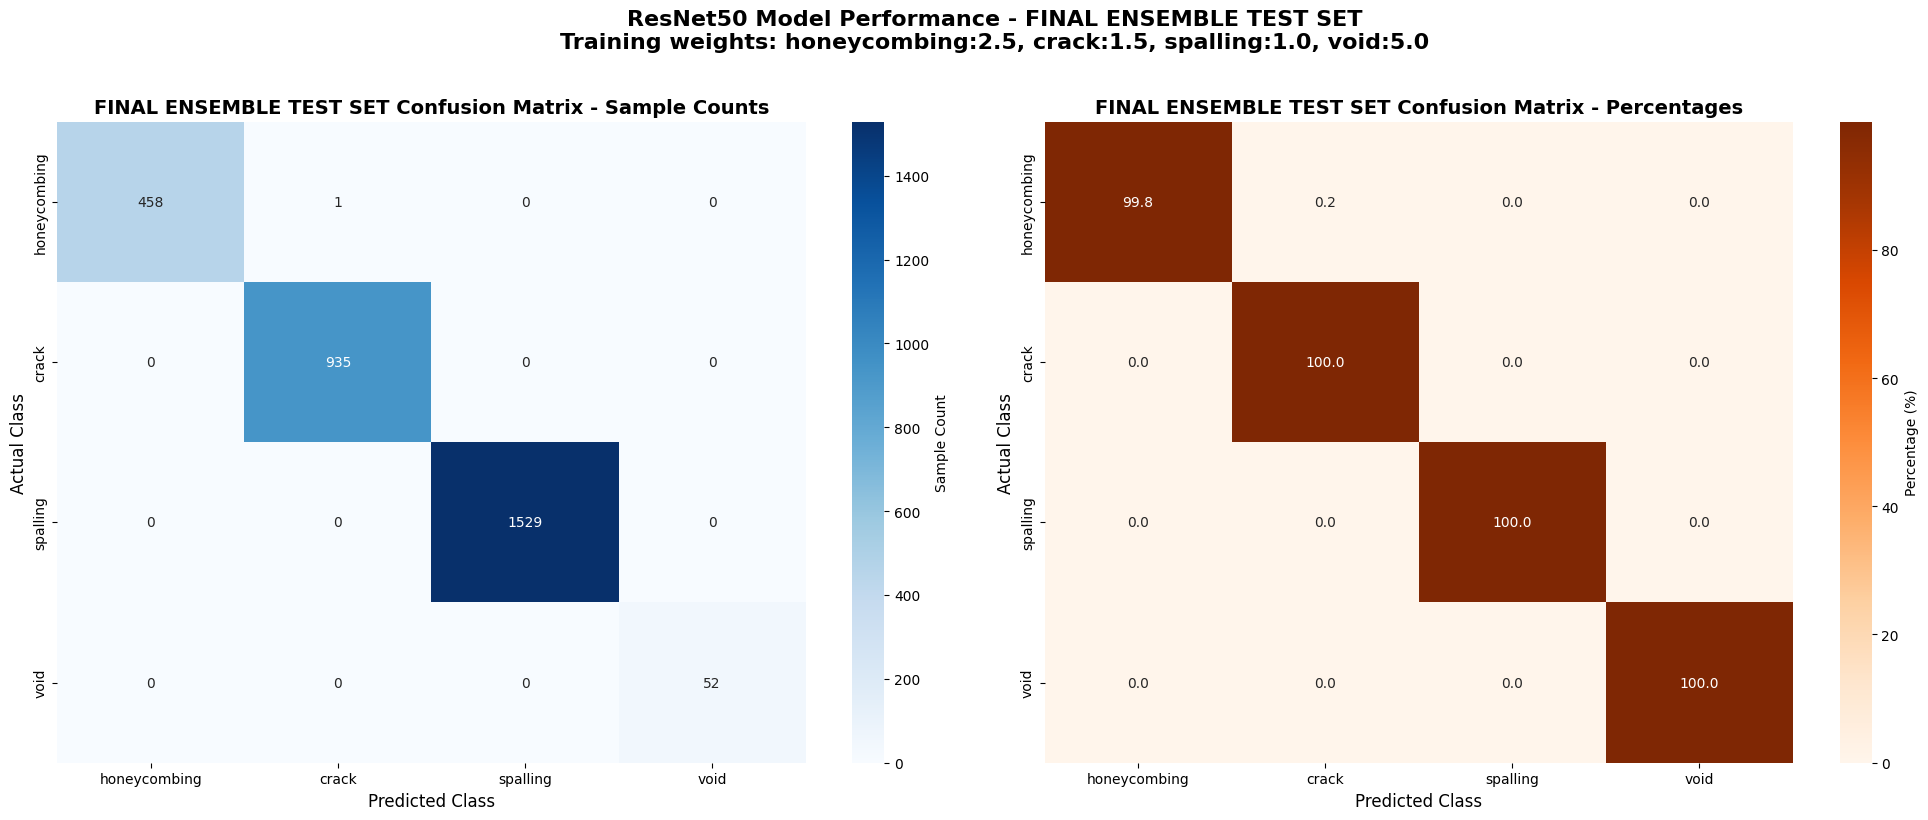


💾 Saving FINAL TEST SET evaluation results to Google Drive...
   Test results saved to: /content/drive/MyDrive/4classwithoutno-defect/Results/evaluation_results_TEST_KFold_4class_kfold_hcsv_20251104_0337.json

🎉🎉 --- All steps complete! --- 🎉🎉


In [ ]:
# --- 1. Create the Final Test Set DataLoader ---
print("Creating DataLoader for the final held-out TEST set...")

# 'test_df' was created in Cell 3 and locked away
test_dataset = ConcreteDefectDataset(test_df, transform=val_transforms, class_to_idx=class_to_idx)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for test set
    num_workers=2,
    pin_memory=True
)
print(f"✅ Test DataLoader created with {len(test_df)} samples in {len(test_loader)} batches.")


# --- 2. Evaluate All 5 Fold Models on the Test Set ---
print(f"\n" + "="*80)
print(f"🏆 Running Evaluation on TEST SET with all {N_SPLITS} Fold Models 🏆")
print("="*80)

all_test_preds = []
all_test_labels = []
all_test_probs = []
fold_test_scores = []

for fold_idx in range(N_SPLITS):
    print(f"\n--- Loading and Evaluating Fold {fold_idx + 1}/{N_SPLITS} ---")

    # Define the model path
    fold_model_path = os.path.join(MODEL_DIR, f'best_model_fold_{fold_idx+1}_{PROJECT_ID}.pth')

    if not os.path.exists(fold_model_path):
        print(f"⚠️ Warning: Model file not found, skipping fold {fold_idx+1}: {fold_model_path}")
        continue

    # Create a fresh model instance
    model = create_model()

    # Load the fold's best weights
    checkpoint = torch.load(fold_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"   Loaded model from: {fold_model_path}")

    # Run the evaluation function (defined in Cell 6)
    # This will print a full report for this single model
    test_results = evaluate_model(model, test_loader, data_set_name=f"TEST (Fold {fold_idx+1})")

    # Store the results for averaging
    all_test_preds.append(test_results['predictions'])
    all_test_probs.append(test_results['probabilities'])
    fold_test_scores.append(test_results['macro_f1'])

    # We only need the true labels once
    if fold_idx == 0:
        all_test_labels = test_results['true_labels']

    del model # Clear model from memory
    if device.type == 'cuda':
        torch.cuda.empty_cache()


print("\n" + "="*80)
print(f"🏁 K-Fold Test Evaluation Complete 🏁")
print("="*80)

# --- 3. Calculate Final Ensemble Metrics ---

# To get a final "ensemble" score, we average the probabilities from all 5 models
# This is a more robust method than "majority vote"
avg_probs = np.mean(all_test_probs, axis=0)
# The final prediction is the class with the highest average probability
final_ensemble_preds = np.argmax(avg_probs, axis=1)

print("\n--- Final ENSEMBLE Performance (Averaged Probabilities) ---")
final_accuracy = accuracy_score(all_test_labels, final_ensemble_preds)
final_macro_f1 = f1_score(all_test_labels, final_ensemble_preds, average='macro', zero_division=0)
final_report = classification_report(all_test_labels, final_ensemble_preds, target_names=class_names, zero_division=0)

print(f"📊 Final Test Accuracy (Ensemble): {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"📈 Final Test Macro F1 (Ensemble): {final_macro_f1:.4f}")
print(f"\n📊 Detailed Ensemble Classification Report:")
print(final_report)


# --- 4. Plot the FINAL ENSEMBLE Confusion Matrix ---
print("\n🎨 Creating FINAL ENSEMBLE TEST SET confusion matrix...")
plot_confusion_matrix(all_test_labels,
                      final_ensemble_preds,
                      class_names,
                      title_prefix="FINAL ENSEMBLE TEST SET")


# --- 5. Save Final TEST Results to a JSON file ---
print("\n💾 Saving FINAL TEST SET evaluation results to Google Drive...")

# Create a summary dictionary
test_eval_summary = {
    'project_id': PROJECT_ID,
    'timestamp': TIMESTAMP,
    'evaluation_type': f"{N_SPLITS}-Fold Cross-Validation Ensemble",
    'dataset_info': {
        'total_images_before_dedupe': total_images,
        'total_unique_images': unique_images,
        'duplicates_removed': duplicate_images,
        'train_val_pool_size': len(train_val_df),
        'test_set_size': len(test_df)
    },
    'final_ensemble_metrics': {
        'accuracy': float(final_accuracy),
        'macro_f1': float(final_macro_f1),
        'classification_report': final_report
    },
    'individual_fold_test_scores (Macro F1)': fold_test_scores,
    'custom_weights': custom_class_weights,
    'batch_size': BATCH_SIZE
}

# Define the save path
test_eval_path = os.path.join(RESULTS_DIR, f'evaluation_results_TEST_KFold_{PROJECT_ID}_{TIMESTAMP}.json')

# Save the file
with open(test_eval_path, 'w') as f:
    json.dump(test_eval_summary, f, indent=4)

print(f"   Test results saved to: {test_eval_path}")
print("\n🎉🎉 --- All steps complete! --- 🎉🎉")